In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Загружаем датасет

In [2]:
df = pd.read_csv('train.csv')
df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


#### Разделяем датасет на признаки и целевое значение. Смотрим типы данных в столбцах. Определяем столбцы, где есть пропуски.

In [3]:
y = df['Price']
X = df
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [4]:
X.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
print('LifeSquare column NaN = ', df['LifeSquare'].isna().sum())
print('Healthcare_1 column NaN = ', df['Healthcare_1'].isna().sum())

LifeSquare column NaN =  2113
Healthcare_1 column NaN =  4798


#### Видим, что в столбце Healthcare_1 слишком много пропусков, его использовать не будем, как и столбец Id. В столбце LifeSquare также много пропусков, его заполним позднее, после подготовки остальных признаков.
#### Далее анализируем столбцы с типом object, т.к. в них присутствует только значения A и B, их можно перевести в значения 0 и 1.

In [6]:
print(X['Ecology_2'].value_counts())
print(X['Ecology_3'].value_counts())
print(X['Shops_2'].value_counts())

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


In [7]:
#X['Ecology_2'] = X['Ecology_2'].map(obj_map)
#X['Ecology_3'] = X['Ecology_3'].map(obj_map)
#X['Shops_2'] = X['Shops_2'].map(obj_map)


#### Проанализируем основные значения построив несколько графиков и посмотрев распеределение значений признаков методом describe().

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002172041E828>,
      dtype=object)

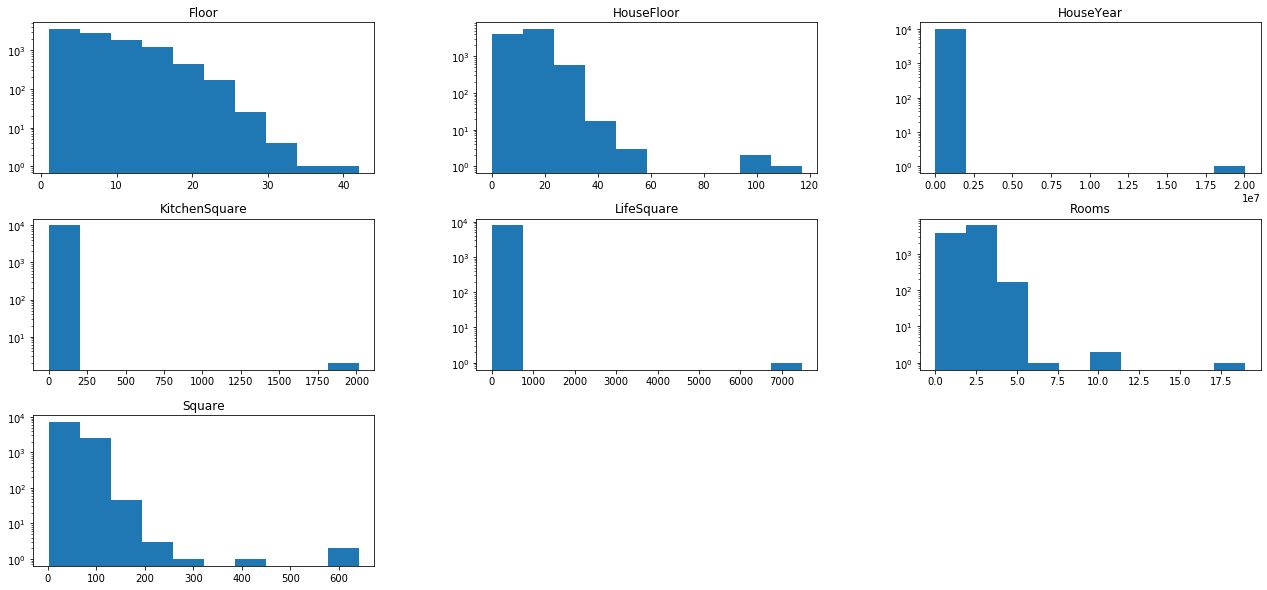

In [8]:
X[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
'HouseFloor', 'HouseYear']].hist(figsize=(22,10),bins = 10, grid = False, log= True)


In [9]:
X.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Видим аномальные значения (нули) и выбросы почти во всех колонках.

#### Начинаем разбираться с пропущенными и некорректными значениями. Сначала исправляем аномальные значения Rooms. Нормальными считаем комнаты от 1 до 5, т.к. у квартир с комнатами больше 5 некорректные для такого кол-ва комнат. остальные признаки. Таких всего 12,  можем заменить их на медианные значения.

In [10]:
X.loc[(X['Rooms'] < 1) | (X['Rooms'] > 5)].shape

(12, 20)

In [11]:
rooms_median = X['Rooms'].median()
X.loc[(X['Rooms'] < 1) | (X['Rooms'] > 5), 'Rooms'] = rooms_median

#### Далее готовимся исправлять остальные признаки. Для заполнения пустых и некорректных значений LifeSquare и KitchenSquare посчитаем на верных значениях среднюю пропорцию LifeSquare и KitchenSquare к Square, относительно кол-ва комнат. Эти значения будем использовать для нормализации как train, так и test. Здесь же посчитаем среднюю цену квартиры по районам, относительно кол-ва комнат, а также просто среднюю цену по кол-ву комнат.

In [12]:
good_lsq = (X['LifeSquare'] < X['Square']) & X['LifeSquare'].notnull() & ((X['LifeSquare'] / X['Square']) >= 0.4)
good_kitchen = (X['KitchenSquare'] < 35) & (X['KitchenSquare'] >= 4)

room1_lsq_mean = (X[good_lsq & (X['Rooms'] == 1.0)]['LifeSquare'] / X[good_lsq & (X['Rooms'] == 1.0)]['Square']).mean()
room2_lsq_mean = (X[good_lsq & (X['Rooms'] == 2.0)]['LifeSquare'] / X[good_lsq & (X['Rooms'] == 2.0)]['Square']).mean()
room3_lsq_mean = (X[good_lsq & (X['Rooms'] == 3.0)]['LifeSquare'] / X[good_lsq & (X['Rooms'] == 3.0)]['Square']).mean()
room4_lsq_mean = (X[good_lsq & (X['Rooms'] == 4.0)]['LifeSquare'] / X[good_lsq & (X['Rooms'] == 4.0)]['Square']).mean()
room5_lsq_mean = (X[good_lsq & (X['Rooms'] == 5.0)]['LifeSquare'] / X[good_lsq & (X['Rooms'] == 5.0)]['Square']).mean()

room1_kitchen_mean = (X[good_kitchen & (X['Rooms'] == 1.0)]['KitchenSquare'] / X[good_kitchen & (X['Rooms'] == 1.0)]['Square']).mean()
room2_kitchen_mean = (X[good_kitchen & (X['Rooms'] == 2.0)]['KitchenSquare'] / X[good_kitchen & (X['Rooms'] == 2.0)]['Square']).mean()
room3_kitchen_mean = (X[good_kitchen & (X['Rooms'] == 3.0)]['KitchenSquare'] / X[good_kitchen & (X['Rooms'] == 3.0)]['Square']).mean()
room4_kitchen_mean = (X[good_kitchen & (X['Rooms'] == 4.0)]['KitchenSquare'] / X[good_kitchen & (X['Rooms'] == 4.0)]['Square']).mean()
room5_kitchen_mean = (X[good_kitchen & (X['Rooms'] == 5.0)]['KitchenSquare'] / X[good_kitchen & (X['Rooms'] == 5.0)]['Square']).mean()

med_price_by_district = X.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_room = X.groupby(['Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByRoom'})

print(room1_lsq_mean, room2_lsq_mean, room3_lsq_mean, room4_lsq_mean, room5_lsq_mean)
print(room1_kitchen_mean, room2_kitchen_mean, room3_kitchen_mean, room4_kitchen_mean, room5_kitchen_mean)


0.6068413669568837 0.6498014121922943 0.6711768418254251 0.6781521565613489 0.7186634142809446
0.19894739168952844 0.14244303529174998 0.11564744438928594 0.09854477309194813 0.08780944706113832


#### При подробном разборе находим допустимые пределы признаков. 
#### Начинаем создавать функцию, для подготовки данных. Посмотрев на признаки квартир с слишком маленькой и слишком большой площадью приходим к выводу об ошибке масштаба в 10 раз, исправляем в первую очередь.
#### Также видим много домов, где этажность здания меньше этажа квартиры, или равна нулю. В нули проставляем медиану. Далее отсеиваем дома, где этаж квартиры превышает этажность дома и выбросы - приравниваем к этажу квартиры.
#### Некорректных значений года здания немного, заменяем медианным значением.

#### Далее исправляем некорректные значения LifeSquare и KitchenSquare, используя ранее рассчитанные средние значения. После этого в квартирах где их сумма превышает Square отнимаем от LifeSquare величину этого превышения. 


#### После этого преобразуем object столбцы в dummy со значениями 1 и 0. Столбец DistrictId преобразуем в доп. признаки -  dummy столбец указывающий большой район, или нет, и столбец со средней ценой квартиры в районе, относительно кол-ва комнат.

#### Последним действием удаляем ненужные для обучения модели признаки и целевое значение.

In [13]:
def data_prepare(df):
    df.loc[(df['Rooms'] < 1) | (df['Rooms'] > 5), 'Rooms'] = rooms_median
    df.loc[(df['Square'] < 15), ['Square', 'LifeSquare']] = df.loc[(df['Square'] < 15), ['Square', 'LifeSquare']] * 10
    df.loc[(df['Square'] > 300), ['Square', 'LifeSquare']] = df.loc[(df['Square'] > 300), ['Square', 'LifeSquare']] / 10
    df.loc[(df['HouseFloor'] == 0), 'HouseFloor'] = df['HouseFloor'].median()
    df.loc[(df['Floor'] > 50), 'Floor'] = df['Floor'].median()
    df.loc[(df['HouseFloor'] < df['Floor']) | (df['HouseFloor'] > 50), 'HouseFloor'] = df.loc[(df['HouseFloor'] < df['Floor']) | (df['HouseFloor'] > 50), 'Floor']
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = df['HouseYear'].median()
    
    bad_lsq = (df['LifeSquare'] > df['Square']) | df['LifeSquare'].isna() | ((df['LifeSquare'] / df['Square']) < 0.4) | (df['LifeSquare'] < 0)
    bad_kitchen = (df['KitchenSquare'] >= 33) | (df['KitchenSquare'] < 4)
    bad_sq = df['Square'] < (df['LifeSquare'] + df['KitchenSquare'])
    df.loc[df['LifeSquare'] < 0, 'LifeSquare'] *= -1
            
    df.loc[bad_lsq & (df['Rooms'] == 1), 'LifeSquare'] = df.loc[bad_lsq & (df['Rooms'] == 1), 'Square'] * room1_lsq_mean
    df.loc[bad_lsq & (df['Rooms'] == 2), 'LifeSquare'] = df.loc[bad_lsq & (df['Rooms'] == 2), 'Square'] * room2_lsq_mean
    df.loc[bad_lsq & (df['Rooms'] == 3), 'LifeSquare'] = df.loc[bad_lsq & (df['Rooms'] == 3), 'Square'] * room3_lsq_mean
    df.loc[bad_lsq & (df['Rooms'] == 4), 'LifeSquare'] = df.loc[bad_lsq & (df['Rooms'] == 4), 'Square'] * room4_lsq_mean
    df.loc[bad_lsq & (df['Rooms'] == 5), 'LifeSquare'] = df.loc[bad_lsq & (df['Rooms'] == 5), 'Square'] * room5_lsq_mean
    
    df.loc[bad_kitchen & (df['Rooms'] == 1), 'KitchenSquare'] = round(df.loc[bad_kitchen & (df['Rooms'] == 1), 'Square'] * room1_kitchen_mean)
    df.loc[bad_kitchen & (df['Rooms'] == 2), 'KitchenSquare'] = round(df.loc[bad_kitchen & (df['Rooms'] == 2), 'Square'] * room2_kitchen_mean)
    df.loc[bad_kitchen & (df['Rooms'] == 3), 'KitchenSquare'] = round(df.loc[bad_kitchen & (df['Rooms'] == 3), 'Square'] * room3_kitchen_mean)
    df.loc[bad_kitchen & (df['Rooms'] == 4), 'KitchenSquare'] = round(df.loc[bad_kitchen & (df['Rooms'] == 4), 'Square'] * room4_kitchen_mean)
    df.loc[bad_kitchen & (df['Rooms'] == 5), 'KitchenSquare'] = round(df.loc[bad_kitchen & (df['Rooms'] == 5), 'Square'] * room5_kitchen_mean)
    
    df.loc[bad_sq, 'LifeSquare'] = df.loc[bad_sq, 'LifeSquare'] - ((df[bad_sq]['LifeSquare'] + df[bad_sq]['KitchenSquare']) - df[bad_sq]['Square'])
    
    obj_map = {'A': 1, 'B': 0}
    df['Ecology_2'] = df['Ecology_2'].map(obj_map)
    df['Ecology_3'] = df['Ecology_3'].map(obj_map)
    df['Shops_2'] = df['Shops_2'].map(obj_map)
          

In [14]:
data_prepare(X)

#### Работу с районами и удаление лишних признаков пришлось вынести за функцию. Внутри функции почему-то не работает.

In [15]:
district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
X = X.merge(district_size, on='DistrictId', how='left')
X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)

X = X.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [16]:
X.drop(['DistrictId', 'Healthcare_1', 'Id', 'Price', 'DistrictSize'], axis=1, inplace=True)  
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 18 columns):
Rooms                 10000 non-null float64
Square                10000 non-null float64
LifeSquare            10000 non-null float64
KitchenSquare         10000 non-null float64
Floor                 10000 non-null float64
HouseFloor            10000 non-null float64
HouseYear             10000 non-null float64
Ecology_1             10000 non-null float64
Ecology_2             10000 non-null int64
Ecology_3             10000 non-null int64
Social_1              10000 non-null int64
Social_2              10000 non-null int64
Social_3              10000 non-null int64
Helthcare_2           10000 non-null int64
Shops_1               10000 non-null int64
Shops_2               10000 non-null int64
IsDistrictLarge       10000 non-null int32
MedPriceByDistrict    10000 non-null float64
dtypes: float64(9), int32(1), int64(8)
memory usage: 1.4 MB


#### Применив функцию видим, что данные нормализованы - нет некорректных значений, выбросов и отклонений.

In [17]:
X.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,IsDistrictLarge,MedPriceByDistrict
0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,0,0,33,7976,5,0,11,0,0,207786.135836
1,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,0,0,46,10309,1,1,16,0,0,300009.450063
2,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,0,0,34,7759,0,1,3,0,1,263206.223152
3,2.0,53.352981,44.352981,9.0,8.0,17.0,1977.0,0.437885,0,0,23,5735,3,0,5,0,1,166809.665642
4,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,0,0,35,5776,1,2,4,0,0,158539.052715


In [18]:
X.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,IsDistrictLarge,MedPriceByDistrict
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,56.219184,36.641232,8.370800,8.526700,13.538000,1984.863800,0.118858,0.009700,0.027500,24.687000,5352.157400,8.039200,1.319500,4.231300,0.082500,0.506900,211502.014083
std,0.811056,19.093886,15.460683,2.431522,5.241148,5.782672,18.409979,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1.493601,4.806341,0.275139,0.499977,76544.901336
min,1.000000,11.368588,8.547242,2.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,82342.775873
25%,1.000000,41.784623,24.849960,7.000000,4.000000,9.000000,1974.000000,0.017647,0.000000,0.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,0.000000,0.000000,165071.825722
50%,2.000000,52.519197,33.268945,8.000000,7.000000,14.000000,1977.000000,0.075424,0.000000,0.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,0.000000,1.000000,195474.299127
75%,2.000000,65.890819,44.780209,10.000000,12.000000,17.000000,2001.000000,0.195781,0.000000,0.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,0.000000,1.000000,241068.903045
max,5.000000,275.645284,233.949309,32.000000,42.000000,48.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,1.000000,624156.003381


#### Переходим к стандартизации признаков

In [19]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'MedPriceByDistrict']
scl = StandardScaler()
scl_f = scl.fit_transform(X[features])

In [20]:
X[features] = pd.DataFrame(scl_f,columns=features)

In [21]:
X.head(5)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,IsDistrictLarge,MedPriceByDistrict
0,0.137605,-0.431449,-0.465622,-0.975076,-0.291306,-0.784798,-0.861739,-0.250529,0,0,0.474169,0.654880,-0.127533,-0.883480,1.408356,0,0,-0.048548
1,1.370628,0.495705,0.220461,-0.152505,-0.291306,-0.784798,-0.372849,-0.998053,0,0,1.215681,1.237169,-0.295384,-0.213923,2.448700,0,0,1.156339
2,0.137605,-0.590335,-0.481479,-0.975076,-0.100498,-0.265980,-0.916060,-0.581588,0,0,0.531208,0.600720,-0.337347,-0.213923,-0.256195,0,1,0.675509
3,0.137605,-0.150119,0.498822,0.258781,-0.100498,0.598715,-0.427170,2.680470,0,0,-0.096225,0.095553,-0.211458,-0.883480,0.159943,0,1,-0.583900
4,-1.095417,-0.867860,-0.832156,-0.563790,0.471924,-0.265980,-0.481491,-0.894969,0,0,0.588247,0.105786,-0.295384,0.455633,-0.048126,0,0,-0.691955


#### Разбиваем на тренировочный и тестовый сеты и начинаем строить и отбирать модели

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 66 )

In [23]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Gradient Boosting. После отбора данная модель показала наилучшие результаты. Были подобраны лучшие параметры.** 

In [24]:
model = GradientBoostingRegressor(n_estimators = 150, max_depth = 5 ,random_state=66)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=66, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Train R2:	0.901
Test R2:	0.754


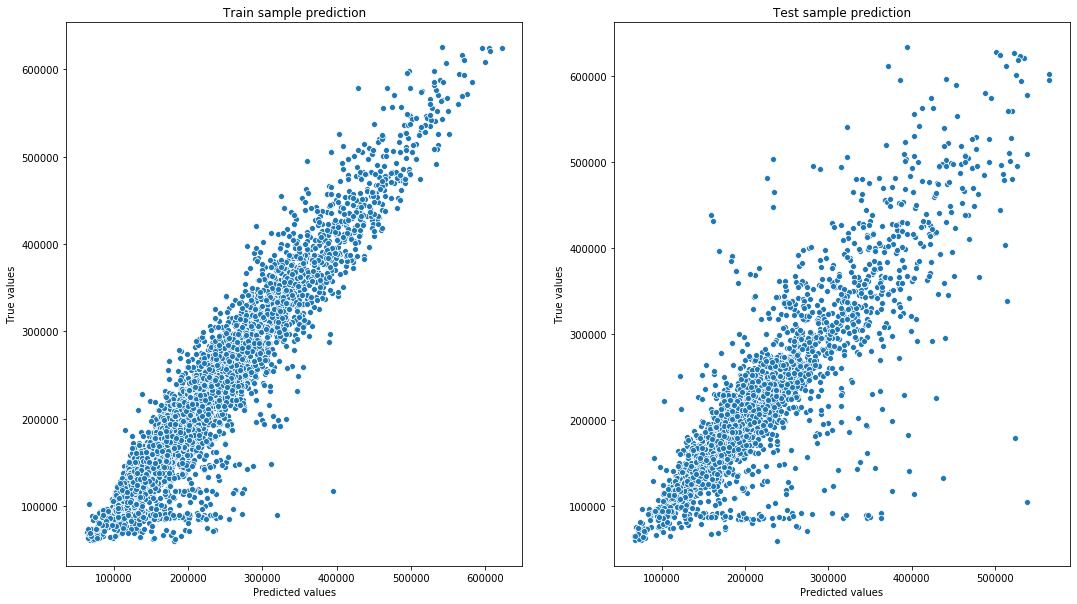

In [25]:
y_pred_ = model.predict(X_train)
y_pred_t = model.predict(X_test)

evaluate_preds(y_train, y_pred_, y_test, y_pred_t)

#### Загружаем тестовый сет

In [26]:
df_t = pd.read_csv('test.csv')
df_t.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


#### Смотрим подробную информаци и видим, что тестовый фрейм аналогичен треноровочному. Используя наработки, подготавливаем признаки.

In [27]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [28]:
X_t = df_t


In [29]:
data_prepare(X_t)

district_size = X_t['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
X_t = X_t.merge(district_size, on='DistrictId', how='left')
X_t['IsDistrictLarge'] = (X_t['DistrictSize'] > 100).astype(int)
X_t = X_t.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')


In [30]:
X_t.drop(['DistrictId', 'Healthcare_1', 'Id', 'DistrictSize'], axis=1, inplace=True)  
X_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
Rooms                 5000 non-null float64
Square                5000 non-null float64
LifeSquare            5000 non-null float64
KitchenSquare         5000 non-null float64
Floor                 5000 non-null float64
HouseFloor            5000 non-null float64
HouseYear             5000 non-null float64
Ecology_1             5000 non-null float64
Ecology_2             5000 non-null int64
Ecology_3             5000 non-null int64
Social_1              5000 non-null int64
Social_2              5000 non-null int64
Social_3              5000 non-null int64
Helthcare_2           5000 non-null int64
Shops_1               5000 non-null int64
Shops_2               5000 non-null int64
IsDistrictLarge       5000 non-null int32
MedPriceByDistrict    4936 non-null float64
dtypes: float64(9), int32(1), int64(8)
memory usage: 722.7 KB


#### В тестовом датасете есть DistrictId которых не было в тренировочном и некоторые значения MedPriceByDistrict остались пустыми. Заполняем их медианными значениями относительно кол-ва комнат.

In [31]:
X_t.loc[(X_t['MedPriceByDistrict'].isna()) & (X_t['Rooms'] == 1), 'MedPriceByDistrict'] = med_price_by_room.loc[0, 'MedPriceByRoom']
X_t.loc[(X_t['MedPriceByDistrict'].isna()) & (X_t['Rooms'] == 2), 'MedPriceByDistrict'] = med_price_by_room.loc[1, 'MedPriceByRoom']
X_t.loc[(X_t['MedPriceByDistrict'].isna()) & (X_t['Rooms'] == 3), 'MedPriceByDistrict'] = med_price_by_room.loc[2, 'MedPriceByRoom']
X_t.loc[(X_t['MedPriceByDistrict'].isna()) & (X_t['Rooms'] == 4), 'MedPriceByDistrict'] = med_price_by_room.loc[3, 'MedPriceByRoom']
X_t.loc[(X_t['MedPriceByDistrict'].isna()) & (X_t['Rooms'] == 5), 'MedPriceByDistrict'] = med_price_by_room.loc[4, 'MedPriceByRoom']

In [32]:
X_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
Rooms                 5000 non-null float64
Square                5000 non-null float64
LifeSquare            5000 non-null float64
KitchenSquare         5000 non-null float64
Floor                 5000 non-null float64
HouseFloor            5000 non-null float64
HouseYear             5000 non-null float64
Ecology_1             5000 non-null float64
Ecology_2             5000 non-null int64
Ecology_3             5000 non-null int64
Social_1              5000 non-null int64
Social_2              5000 non-null int64
Social_3              5000 non-null int64
Helthcare_2           5000 non-null int64
Shops_1               5000 non-null int64
Shops_2               5000 non-null int64
IsDistrictLarge       5000 non-null int32
MedPriceByDistrict    5000 non-null float64
dtypes: float64(9), int32(1), int64(8)
memory usage: 722.7 KB


#### Теперь можно стандартизировать данные и применять модель.

In [33]:
X_t.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,IsDistrictLarge,MedPriceByDistrict
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.906200,56.546504,36.865517,8.293000,8.61780,13.473800,1984.392600,0.119874,0.009600,0.029800,24.933800,5406.900000,8.262600,1.31940,4.242800,0.082400,0.325000,212116.831507
std,0.805935,19.050096,15.032985,2.380816,5.39477,5.959129,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,1.47994,4.777365,0.275001,0.468422,73690.366470
min,1.000000,13.785426,9.698766,3.000000,1.00000,1.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,0.000000,84250.557673
25%,1.000000,41.926034,25.024756,6.000000,4.00000,9.000000,1973.000000,0.019509,0.000000,0.000000,6.000000,1564.000000,0.000000,0.00000,1.000000,0.000000,0.000000,165700.355193
50%,2.000000,52.933734,33.656375,8.000000,7.00000,14.000000,1977.000000,0.072158,0.000000,0.000000,25.000000,5285.000000,2.000000,1.00000,3.000000,0.000000,0.000000,197795.571830
75%,2.000000,66.295632,45.226224,10.000000,12.00000,17.000000,2000.000000,0.195781,0.000000,0.000000,36.000000,7287.000000,5.000000,2.00000,6.000000,0.000000,1.000000,240748.194575
max,5.000000,223.453689,151.729035,32.000000,46.00000,48.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.00000,23.000000,1.000000,1.000000,593618.746096


In [34]:
scl_f_t = scl.transform(X_t[features])

In [35]:
X_t[features] = pd.DataFrame(scl_f_t, columns=features)

In [36]:
Y = model.predict(X_t)

In [37]:
df_t['Price'] = Y

In [38]:
df_t[['Rooms', 'Price']].head(10)


,Rooms,Price
0,2.0,160513.678652
1,2.0,275753.593668
2,1.0,178625.551459
3,2.0,344511.226171
4,1.0,135092.063004
5,1.0,221264.203742
6,2.0,162744.449871
7,2.0,215828.523190
8,3.0,290040.702401
9,3.0,191465.558109


In [39]:
df_t.to_csv('SFilkin_predictions.csv', sep=',', columns=['Id', 'Price'], index=False)